In [1]:
from matchms.importing import load_from_mgf
path_data = "/home/ioannis/thesis/data/merged_and_cleaned_libraries_1.mgf"
spectrums = list(load_from_mgf(path_data))
print(len(spectrums))


1017531


In [2]:
spectrums[0].metadata

{'charge': 1,
 'description': 'ENAMMOL',
 'formula': 'C20H20FNO4',
 'inchi': 'InChI=1S/C20H20FNO4/c1-25-17-7-3-6-15-16-10-22(9-13-4-2-5-14(21)8-13)11-20(16,19(23)24)12-26-18(15)17/h2-8,16H,9-12H2,1H3,(H,23,24)/t16-,20-/m1/s1',
 'smiles': 'COc1cccc2c1OC[C@]1(C(=O)O)CN(Cc3cc(F)ccc3)C[C@H]21',
 'feature_id': '20240405_pluskal_enammol_5004_A22_id_MSn_positive.mzML msn trees:17',
 'adduct': '[M+Na]+',
 'feature_ms1_height': '4.404E7',
 'spectype': 'SAME_ENERGY',
 'collision_energy': '60.0',
 'fragmentation_method': 'HCD',
 'isolation_window': '1.2000000476839432',
 'acquisition': 'Commercial',
 'ims_type': 'none',
 'ion_source': 'ESI',
 'ionmode': 'positive',
 'dataset_id': 'MSV000094528',
 'usi': '[mzspec:MSV000094528:20240405_pluskal_enammol_5004_A22_id_MSn_positive:256, mzspec:MSV000094528:20240405_pluskal_enammol_5004_A22_id_MSn_positive:786]',
 'scans': '256,786',
 'precursor_purity': '1.0',
 'quality_chimeric': 'PASSED',
 'quality_explained_intensity': '0.96458876',
 'quality_explaine

In [3]:
from collections import Counter
data_collector = [spectrum.get("data_collector") for spectrum in spectrums]
print(Counter(data_collector))

Counter({None: 712659, 'Corinna Brungs': 304872})


Select only the spectra coming from MSn Library:

In [4]:
msn_filtered = [spectrum for spectrum in spectrums if spectrum.get("data_collector") == "Corinna Brungs"]
print(len(msn_filtered))

304872


Check the variance in different mass analyzers. From the paper, MSn Library was created by using: Orbitrap

In [12]:
print("Instrument types:", Counter([s.get("ms_mass_analyzer") for s in msn_filtered]))

Instrument types: Counter({'Orbitrap': 304872})


In [5]:
ionmode = [spectrum.get('ionmode') for spectrum in msn_filtered]
print(Counter(ionmode))

Counter({'positive': 191308, 'negative': 113564})


Check that every spectra in the dataset has the metadata needed for curation

In [13]:
def check_completeness(spectra, metadata):
    total = len(spectra)
    counts = Counter()
    for spectrum in spectra:
        for category in metadata:
            info = spectrum.get(category)
            if info is not None and str(info).strip() != "":
                counts[category] += 1

    print(f"Total spectra: {total}")
    for category in metadata:
        completeness = (counts[category] / total * 100) if total else 0
        print(f"{category:16s}: {counts[category]:6d} / {total}  ({completeness:5.2f}%)")

In [15]:
metadata = ['description', 'formula', 'inchi', 'smiles', 'adduct', 'inchikey', 'collision_energy']
check_completeness(msn_filtered, metadata)

Total spectra: 304872
description     : 304872 / 304872  (100.00%)
formula         : 304872 / 304872  (100.00%)
inchi           : 304872 / 304872  (100.00%)
smiles          : 304872 / 304872  (100.00%)
adduct          : 304872 / 304872  (100.00%)
inchikey        : 304872 / 304872  (100.00%)
collision_energy: 304872 / 304872  (100.00%)


Split the dataset into positive and negative ionmodes

In [7]:
msn_filtered_pos = [spectrum for spectrum in msn_filtered if spectrum.get("ionmode") == "positive"]
print('Positive: ' , (len(msn_filtered_pos)))
msn_filtered_neg = [spectrum for spectrum in msn_filtered if spectrum.get("ionmode") == "negative"]
print('Negative: ' , (len(msn_filtered_neg)))

Positive:  191308
Negative:  113564


In [10]:
def check_subset(spectra, label):
    print(f"\n--- {label} ---")
    print("Count:", len(spectra))
    print("Adducts:", Counter([s.get("adduct") for s in spectra]))
    print("Instrument types:", Counter([s.get("ms_mass_analyzer") for s in spectra]))
    print("Collision energies:", Counter([s.get("collision_energy") for s in spectra]))

Check the variance in Adducts and in Collision energies of both datasets. Variance is needed to ensure generalization of the ML model later on

In [11]:
check_subset(msn_filtered_pos, "Positive mode")
check_subset(msn_filtered_neg, "Negative mode")


--- Positive mode ---
Count: 191308
Adducts: Counter({'[M+H]+': 177085, '[M-H2O+H]+': 5565, '[M+NH4]+': 5048, '[M+Na]+': 2129, '[M]+': 819, '[M-2H2O+H]+': 599, '[M-H2O]+': 63})
Instrument types: Counter({'Orbitrap': 191308})
Collision energies: Counter({'60.0': 68077, '20.0': 61757, '30.0': 30364, '45.0': 17286, '15.0': 13578, '75.0': 246})

--- Negative mode ---
Count: 113564
Adducts: Counter({'[M-H]-': 75014, '[M+FA-H]-': 28069, '[M+Cl]-': 10382, '[M]-': 99})
Instrument types: Counter({'Orbitrap': 113564})
Collision energies: Counter({'60.0': 39913, '20.0': 36399, '15.0': 15080, '30.0': 13835, '45.0': 8246, '75.0': 91})


In [37]:
from collections import defaultdict
from matchms.similarity import CosineGreedy
from matchms import calculate_scores


Check for duplicates in the dataset, meaning spectra that share the same InChIKey, adduct, collision_energy. Compute the similarity of those spectra using cosine score, if it is lower than 0.99 are kept. If the similarity exceeds 0.99 the spectra are redundant and only one is kept, the one with the highest quality_explained_intensity. When building a reference dataset for the model, it is important to avoid redundancy in order to avoid bias.

In [ ]:
def filter_redundant_spectra(spectra, similarity_threshold=0.99):
    """
    Remove redundant spectra within (InChIKey, adduct, collision_energy) groups.
    Spectra in the same group are compared by cosine similarity; if all exceed
    the threshold, only the spectrum with the highest
    'quality_explained_intensity' is kept. Otherwise, all spectra in the group
    are retained.

    Parameters
    ----------
    spectra : list of matchms.Spectrum
        Input spectra to filter.
    similarity_threshold : float, optional
        Cosine similarity cutoff for redundancy (default = 0.99).

    Returns
    -------
    filtered_spectra : list of matchms.Spectrum
        Deduplicated spectra.
    low_similarity_pairs : list of tuple (ref_idx, other_idx, score, shared_peaks)
        Spectrum pairs below the threshold.
    high_similarity_pairs : list of tuple (ref_idx, other_idx, score, shared_peaks)
        Spectrum pairs above the threshold.
    """

    # Group spectra that have the same compound-adduct-collision energy
    # This ensures spectra with different adducts or collision energies are treated separately
    grouped_spectra = defaultdict(list)
    for index, spectrum in enumerate(spectra):
        key = (
    spectrum.get("inchikey"),
    spectrum.get("adduct"),
    spectrum.get("collision_energy")
)
        grouped_spectra[key].append(index)

    similarity_function = CosineGreedy()
    kept_indices = []           # Indices of spectra to retain
    low_similarity_pairs = []   # Pairs of spectra that failed similarity threshold
    high_similarity_pairs = []  # Redundant pairs with similarity > 0.99

    # Iterate over each group of spectra
    for group_indices in grouped_spectra.values():
        # If group has only one spectrum, keep it directly
        if len(group_indices) == 1:
            kept_indices.append(group_indices[0])
            continue

        # Use the first spectrum in the group as reference
        reference_index = group_indices[0]
        reference_spectrum = spectra[reference_index]
        all_similar = True

        # Compare reference to all other spectra in the group
        for other_index in group_indices[1:]:
            other_spectrum = spectra[other_index]
            scores = calculate_scores(
                references=[reference_spectrum],
                queries=[other_spectrum],
                similarity_function=similarity_function
            )
            for _, _, score in scores:
                cosine_score = score[0]
                shared_peaks = score[1]

                # If similarity is below threshold, mark group as non-redundant
                if cosine_score < similarity_threshold:
                    all_similar = False
                    low_similarity_pairs.append(
                        (reference_index, other_index, cosine_score, shared_peaks)
                    )
                else:
                    high_similarity_pairs.append(   
                        (reference_index, other_index, cosine_score, shared_peaks)
                    )

        # Decide which spectra to keep if all spectra are >0.99 similarity
        if all_similar:
            # Keep the spectrum with highest explained intensity
            best_index = max(
                group_indices,
                key=lambda i: float(spectra[i].get("quality_explained_intensity", 0))
            )
            kept_indices.append(best_index)
        else:
            # Keep all spectra in the group if they differ significantly
            kept_indices.extend(group_indices)

    # Build filtered spectrum list from retained indices
    filtered_spectra = [spectra[i] for i in kept_indices]

    # Print summary of filtering results
    print(f"Original spectra: {len(spectra)}")
    print(f"Filtered spectra: {len(filtered_spectra)}")
    print(f"Low similarity pairs flagged: {len(low_similarity_pairs)}")

    return filtered_spectra, low_similarity_pairs, high_similarity_pairs

In [53]:
filtered_pos, low_pairs, high_pairs = filter_redundant_spectra(msn_filtered_pos)

Original spectra: 191308
Filtered spectra: 132736
Low similarity pairs flagged: 8098


As seen above, approximately 30% of the spectra were redundant and removed from the library.

InChIKey: TWIMAQLGJSZRPW-UHFFFAOYSA-N
Adduct: [M+H]+
Collision Energy: 20.0
Cosine similarity: 0.975, Shared peaks: 11
----------------------------------------
InChIKey: FDQFTGXHOIXOCY-UHFFFAOYSA-N
Adduct: [M-H2O+H]+
Collision Energy: 60.0
Cosine similarity: 0.949, Shared peaks: 12
----------------------------------------


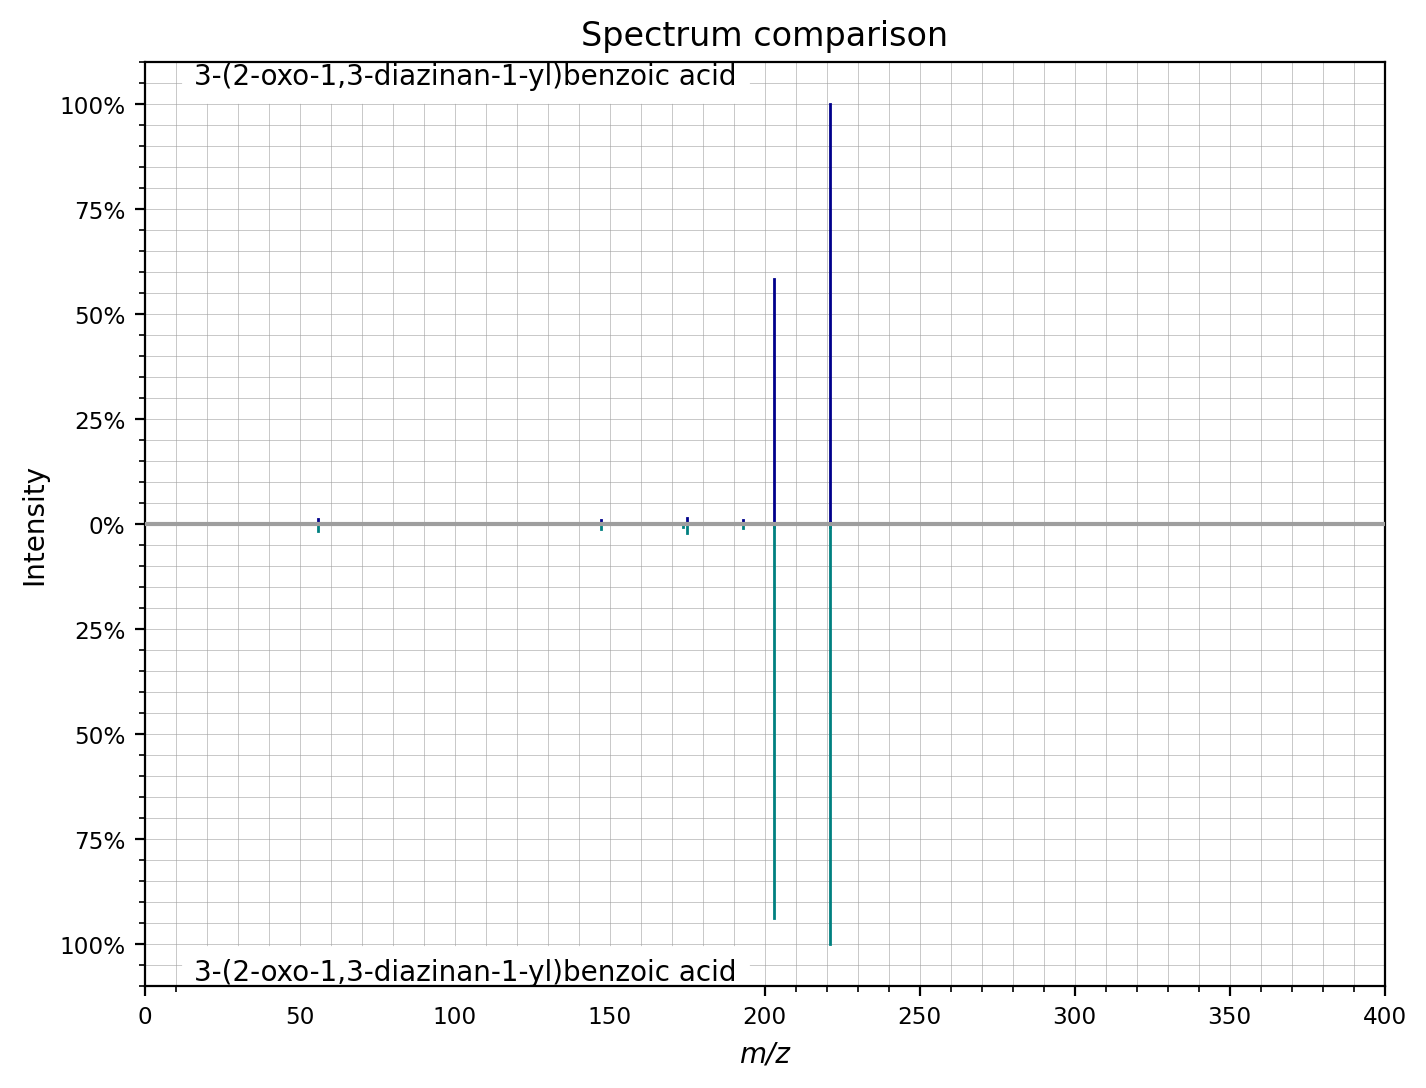

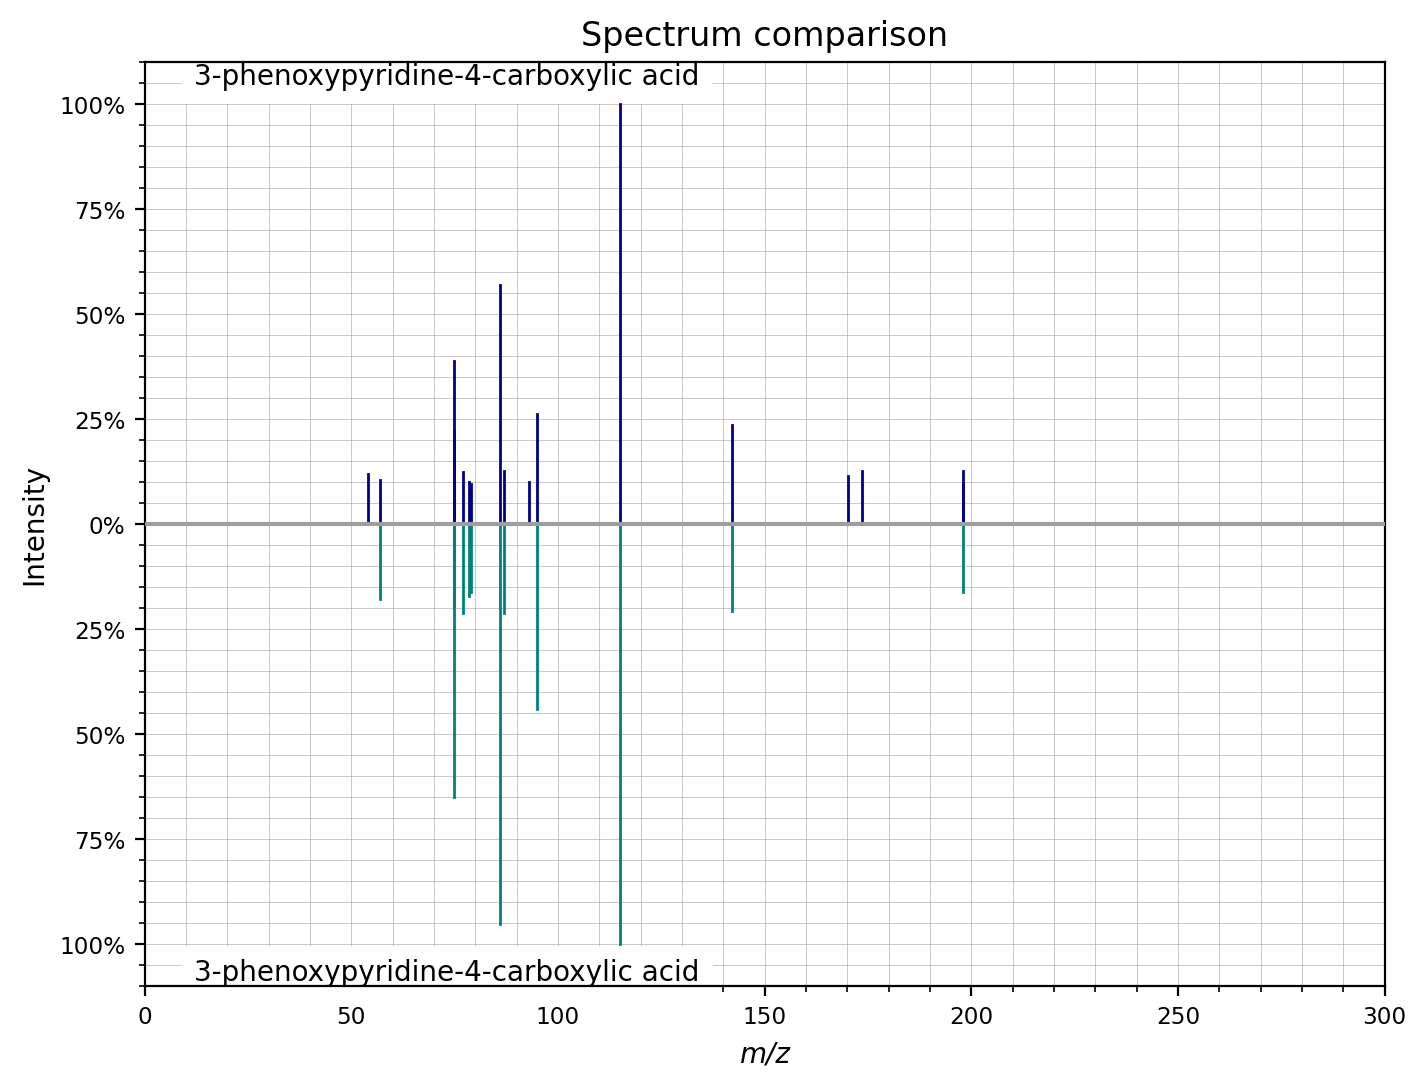

In [54]:
# Plot a few flagged pairs with cos < 0.99 to visually inspect similarity
num_to_plot = 2 

for ref_idx, other_idx, score, shared_peaks in low_pairs[:num_to_plot]:
    ref_spec = msn_filtered_pos[ref_idx]
    other_spec = msn_filtered_pos[other_idx]

    print(f"InChIKey: {ref_spec.get('inchikey')}")
    print(f"Adduct: {ref_spec.get('adduct')}")
    print(f"Collision Energy: {ref_spec.get('collision_energy')}")
    print(f"Cosine similarity: {score:.3f}, Shared peaks: {shared_peaks}")
    print("-" * 40)

    # Mirror plot
    ref_spec.plot_against(other_spec)


InChIKey: UTXPDZFPPUZUBK-OXQOHEQNSA-N
Adduct: [M+Na]+
Collision Energy: 60.0
Cosine similarity: 0.9999960714453845 Shared peaks: 195
----------------------------------------
InChIKey: UTXPDZFPPUZUBK-OXQOHEQNSA-N
Adduct: [M+Na]+
Collision Energy: 30.0
Cosine similarity: 0.9999958175013847 Shared peaks: 34
----------------------------------------


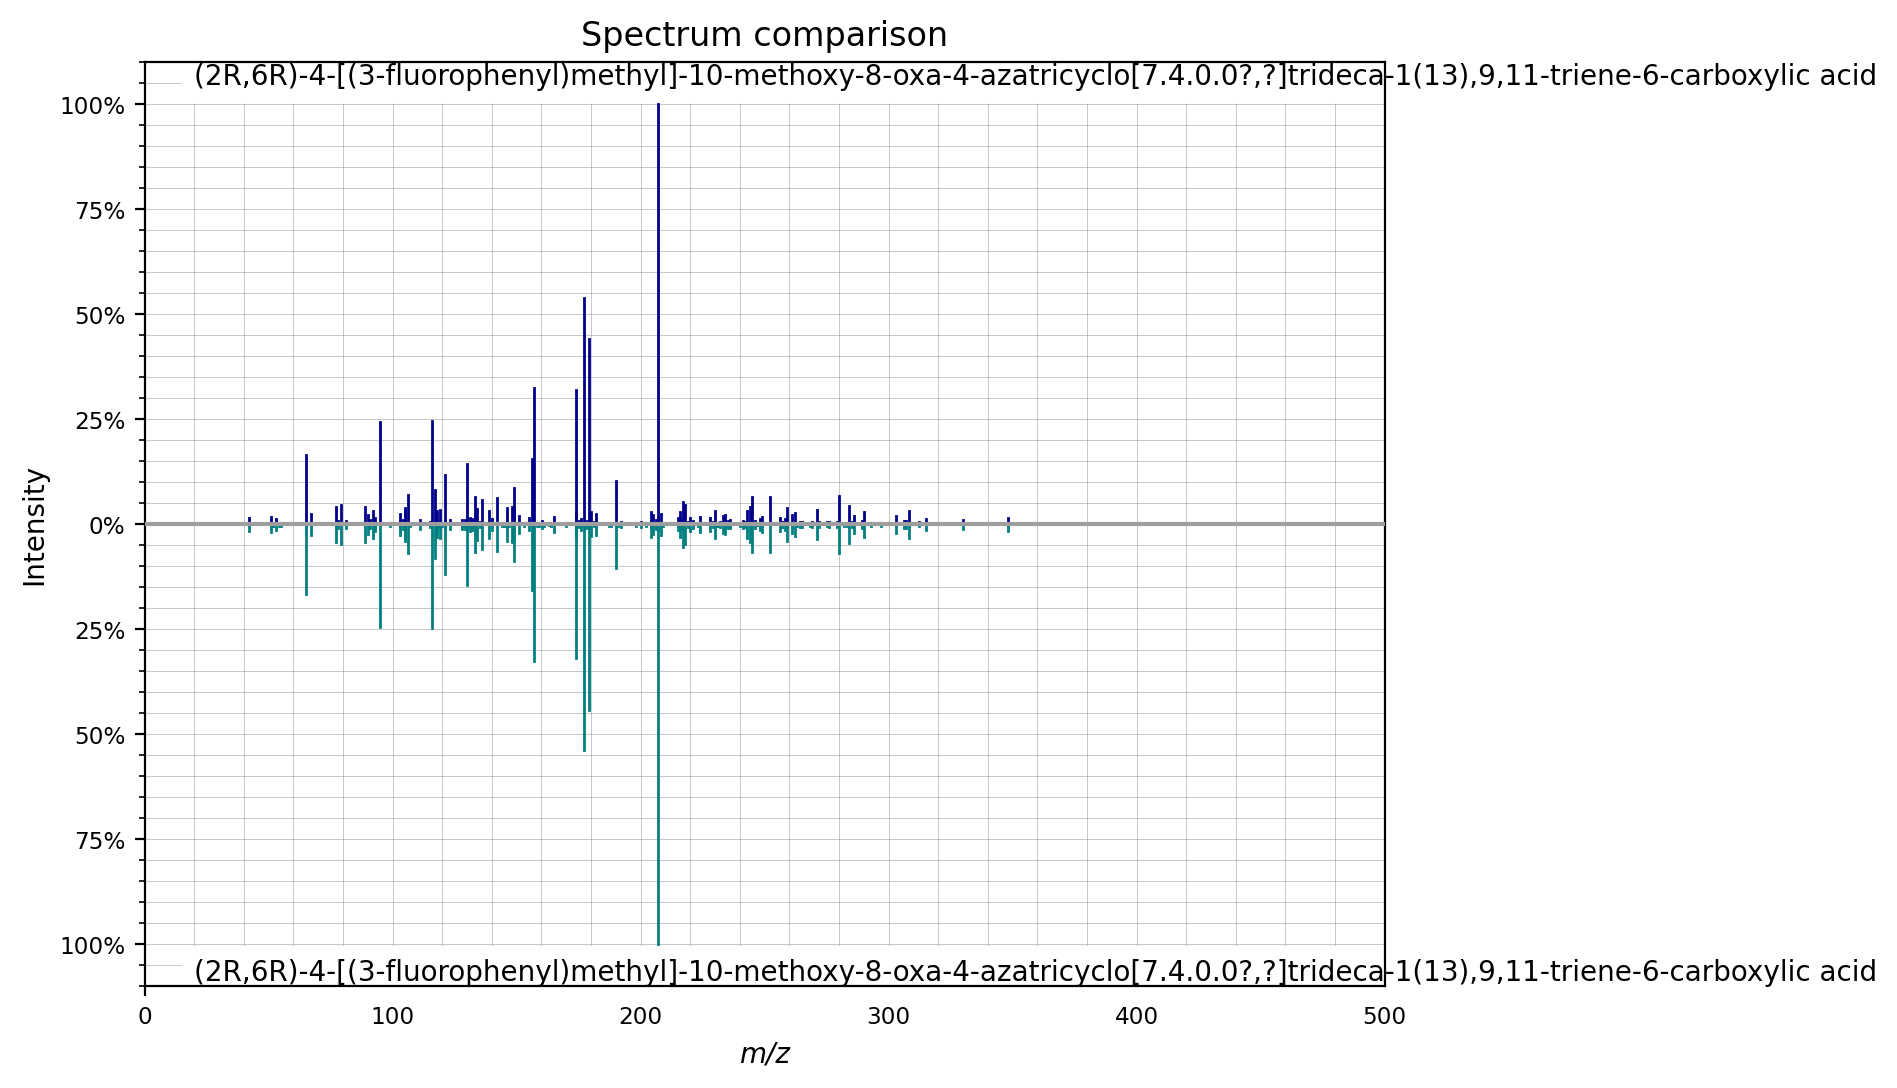

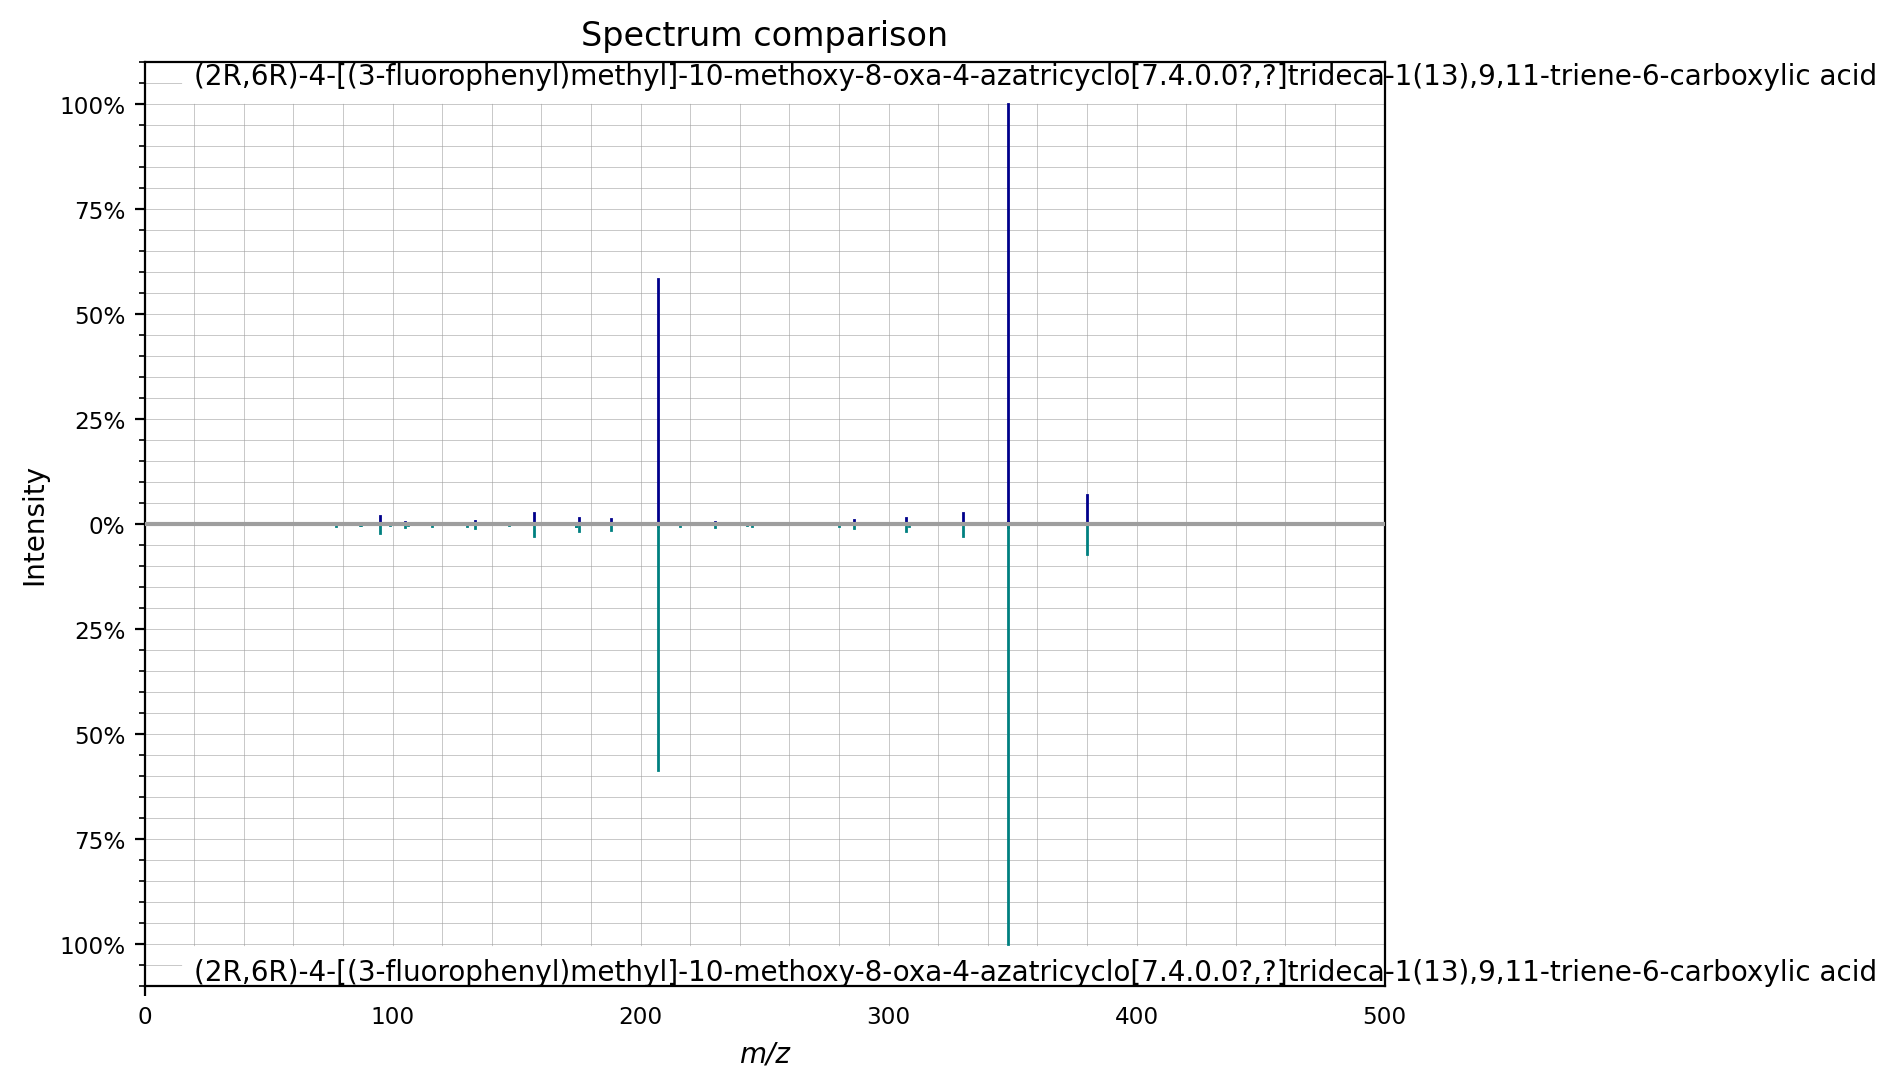

In [55]:
# Plot a few of the redundant (>0.99) pairs
for ref_idx, other_idx, score, shared_peaks in high_pairs[:2]:
    ref_spec = msn_filtered_pos[ref_idx]
    other_spec = msn_filtered_pos[other_idx]

    print("InChIKey:", ref_spec.get("inchikey"))
    print("Adduct:", ref_spec.get("adduct"))
    print("Collision Energy:", ref_spec.get("collision_energy"))
    print("Cosine similarity:", score, "Shared peaks:", shared_peaks)
    print("-" * 40)

    ref_spec.plot_against(other_spec)

The same process now for the negative ionization mode:

In [50]:
filtered_neg, flagged_neg = filter_redundant_spectra(msn_filtered_neg)

Original spectra: 113564
Filtered spectra: 86709
Low similarity pairs flagged: 4509


In [51]:
(86709 / 113564) * 100

76.35254129829876

For the spectra with negative ionization mode, 24% were discarded as they had similarity over 0.99 and the same InChIKey, adduct, collision_energy

In [56]:
from matchms.exporting import save_as_mgf

# Save negative mode spectra
save_as_mgf(filtered_neg, "msn_negative_filtered.mgf")

# Save positive mode spectra
save_as_mgf(filtered_pos, "msn_positive_filtered.mgf")


dict_keys(['spectra'])
dict_keys(['spectra'])
